In [2]:
import os
import collections
from collections import defaultdict
from tqdm import tqdm
import json
import pickle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pandas as pd
from langdetect import detect, LangDetectException

import matplotlib.pyplot as plt
from adjustText import adjust_text

import langid
from src.wimbd_ import WimbdAnalysis, load_mmlu, load_bigbench

In [4]:
n_gram_freqs_path = "./results/n-grams/exp_full/2/common/pl-en-2-grams.pkl"
n_gram_freqs = pickle.load(open(n_gram_freqs_path, "rb"))
n_gram_freqs = dict(sorted(n_gram_freqs.items(), key=lambda item: item[1]['value'], reverse=True))
# # export as text
# # with open("n_gram_freqs.txt", "w") as f:
# #     for k, v in n_gr
# # 3am_freqs.items():
# #         f.write(f"{k}: {v}\n")
# LANGUAGES = ['ru-en', 'fr-en', 'ro-en', 'de-en', 'pl-en', 'cs-en']
# LANGUAGES = ['ru-en', 'ro-en', 'de-en', 'pl-en', 'cs-en', 'fr-en', 'ja-en', 'zh-en']

# wmt09
ds = load_bigbench()

[autoreload of typing_extensions failed: Traceback (most recent call last):
  File "/local/home/antonis/.conda/envs/incidental/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/local/home/antonis/.conda/envs/incidental/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/local/home/antonis/.conda/envs/incidental/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/local/home/antonis/.conda/envs/incidental/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/local/home/antonis/.conda/envs/incidental/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: can't apply this __setattr__ to _T

In [18]:
task_ds

DatasetDict({
    default: Dataset({
        features: ['idx', 'inputs', 'targets', 'multiple_choice_targets', 'multiple_choice_scores'],
        num_rows: 3750
    })
    train: Dataset({
        features: ['idx', 'inputs', 'targets', 'multiple_choice_targets', 'multiple_choice_scores'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['idx', 'inputs', 'targets', 'multiple_choice_targets', 'multiple_choice_scores'],
        num_rows: 750
    })
})

In [28]:
len(ds.keys())

17

min_samples: 181
max_samples: 50000


(0.0, 500.0)

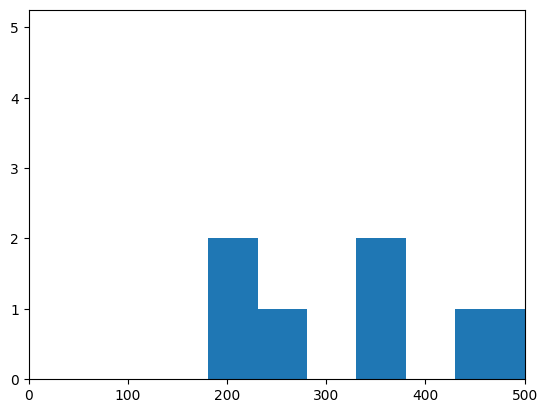

In [27]:
# find min/max num samples
min_samples = 10000
max_samples = 0
n_samnples = []
for task in ds:
    task_ds = ds[task]['default']
    len_task = len(task_ds)
    if len_task < min_samples:
        min_samples = len_task
    if len_task > max_samples:
        max_samples = len_task
    n_samnples.append(len_task)

print(f"min_samples: {min_samples}")
print(f"max_samples: {max_samples}")

# plot sample distribution between 0 and 500
plt.hist(n_samnples, bins=1000)
plt.xlim(0, 500)

In [10]:
# lang params
N_GRAMS = 2
BASE_PATH = f"./results/n-grams/bigbench/exp2_fullds_5000/{N_GRAMS}"
BASE_PATH_COMMON = os.path.join(BASE_PATH, "all")
BASE_PATH_ALL = os.path.join(BASE_PATH, "all")
FILTER_CHARS = False
DETECT_LANG = False
LOG_AXIS = True
TASK = "MMLU/hendrycks*"
SHOT = "5-shot"

# model params
base_results_path = "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/pythia/experiment_3/inference/EleutherAI"
models = ['pythia-12b', 'pythia-6.9b', 'pythia-2.8b', 'pythia-1.4b', 'pythia-410m', 'pythia-160m', 'pythia-70m', 'pythia-31m', 'pythia-14m',]


In [11]:
TASKS_OMMIT = ["formal_logic"]
TASKS = [t for t in list(ds.keys()) if t not in TASKS_OMMIT]
wa = WimbdAnalysis(BASE_PATH, TASKS, N_GRAMS, FILTER_CHARS)

In [12]:
task_dfs = wa.get_task_dfs(BASE_PATH_COMMON, TASKS, filter_chars=FILTER_CHARS)
task_dfs_filtered = wa.get_task_dfs(BASE_PATH, TASKS, filter_chars=True)
# task_dfs

# get total samples per language pair
task_dfs_total_samples = {lang: df['value'].sum() for lang, df in task_dfs.items()}
colors = sns.color_palette('hls', len(task_dfs))
color_mapping = {lang: color for lang, color in zip(task_dfs.keys(), colors)}

In [13]:
total_samples = 0
for task in TASKS:
    total_samples += task_dfs_total_samples[task]
print(f"Total samples: {total_samples}")

Total samples: 954686


In [15]:
task_dfs

{'tracking_shuffled_objects':                       index value  \
 3           game start game  4128   
 4         match start match  1232   
 5   present different color   987   
 6           white ball game   870   
 7             red ball game   644   
 ..                      ...   ...   
 70          event bob black     2   
 71          event alice red     2   
 72      dave playing center     1   
 73       left winger claire     1   
 74    great gatsby gertrude     1   
 
                                               example  \
 3   {'idx': 58, 'inputs': 'Alice, Bob, and Claire ...   
 4   {'idx': 393, 'inputs': 'Alice, Bob, and Claire...   
 5   {'idx': 353, 'inputs': 'Alice, Bob, Claire, Da...   
 6   {'idx': 58, 'inputs': 'Alice, Bob, and Claire ...   
 7   {'idx': 694, 'inputs': 'Alice, Bob, Claire, Da...   
 ..                                                ...   
 70  {'idx': 432, 'inputs': 'Alice, Bob, Claire, Da...   
 71  {'idx': 690, 'inputs': 'Alice, Bob, Claire, 

In [14]:
coverage_path_common = os.path.join(BASE_PATH, "common", "task-coverage.pkl")
coverage_path_all = os.path.join(BASE_PATH, "all", "task-coverage.pkl")

with open(coverage_path_common, "rb") as f:
    coverage_common = pickle.load(f)

with open(coverage_path_all, "rb") as f:
    coverage_all = pickle.load(f)

coverage_common = pd.DataFrame(coverage_common)
coverage_common = coverage_common[coverage_common['task'].isin(TASKS)]

coverage_all = pd.DataFrame(coverage_all)
coverage_all = coverage_all[coverage_all['task'].isin(TASKS)]

task_cov_common = coverage_common.groupby('task')['coverage'].mean().to_dict()
task_cov_all = coverage_all.groupby('task')['coverage'].mean().to_dict()


# now get avg task coverage
N_GRAM_LIST = range(2, 7)
task_coverage = defaultdict(list)
for n_grams in N_GRAM_LIST:
    base_path = f"./results/n-grams/mmlu/exp1/{n_grams}"
    coverage_path_common = os.path.join(base_path, "common", "task-coverage.pkl")
    coverage_path_all = os.path.join(base_path, "all", "task-coverage.pkl")

    with open(coverage_path_common, "rb") as f:
        coverage_common = pickle.load(f)

    with open(coverage_path_all, "rb") as f:
        coverage_all = pickle.load(f)

    coverage_common = pd.DataFrame(coverage_common)
    coverage_common = coverage_common[coverage_common['task'].isin(TASKS)]

    coverage_all = pd.DataFrame(coverage_all)
    coverage_all = coverage_all[coverage_all['task'].isin(TASKS)]

    task_cov_common = coverage_common.groupby('task')['coverage'].mean().to_dict()
    task_cov_all = coverage_all.groupby('task')['coverage'].mean().to_dict()

    for task in TASKS:
        task_coverage[task].append(task_cov_common[task])

task_coverage = pd.DataFrame(task_coverage)
task_coverage = task_coverage.melt().rename(columns={"variable": "task", "value": "coverage"})
task_cov_mean = task_coverage.groupby('task')['coverage'].mean().to_dict()

FileNotFoundError: [Errno 2] No such file or directory: './results/n-grams/bigbench/exp2_fullds_5000/2/common/task-coverage.pkl'

In [51]:
pth = "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/results/n-grams/mmlu/exp1/4/common/task-coverage.pkl"

with open(pth, "rb") as f:
    df = pickle.load(f)

pd.DataFrame(df)

[nltk_data] Downloading package punkt to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,task,example,coverage
0,abstract_algebra,{'question': 'Find the degree for the given fi...,0
1,abstract_algebra,"{'question': 'Let p = (1, 2, 5, 4)(2, 3) in S_...",1
2,abstract_algebra,{'question': 'Find all zeros in the indicated ...,1
3,abstract_algebra,{'question': 'Statement 1 | A factor group of ...,1
4,abstract_algebra,{'question': 'Find the product of the given po...,0
...,...,...,...
14037,world_religions,{'question': 'What has been a central focus of...,0
14038,world_religions,{'question': ' To whom did ordinary folk appea...,0
14039,world_religions,{'question': ' The theological term homoousios...,0
14040,world_religions,{'question': 'According to the Japanese origin...,0


In [52]:
save_path = f"./results/n-grams/exp_full/{N_GRAMS}/common"
# # for each language, save top 100 examples in a csv

# for lang, df in lang_dfs.items():
#     df = df.sort_values(by=['value'], ascending=False)
#     df.to_csv(os.path.join(save_path, f"{lang}_samples.csv"), index=False)

# for lang, df in lang_dfs_filtered.items():
#     df = df.sort_values(by=['value'], ascending=False)
#     df = df.head(100)
#     df.to_csv(os.path.join(save_path, f"{lang}_samples_filtered.csv"), index=False)


In [53]:
# n_gram_freqs.pop(('angela merkel', 'chancellor angela'))
n_gram_freqs_values = [v['value'] for v in n_gram_freqs.values()]
n_gram_freqs_values_cumsum = np.cumsum(n_gram_freqs_values)


In [54]:
# # Usage:
# wa.plot_n_samples(task_dfs, color_mapping)
# # wa.plot_n_samples(lang_dfs_filtered, color_mapping)

In [55]:
model_colormap = plt.cm.get_cmap('coolwarm', len(models))
model_color_mapping = {model: model_colormap(1 - i / len(models)) for i, model in enumerate(models)}


# wa.analyze_and_plot_distributions(task_dfs)



/tmp/ipykernel_175540/2762677078.py:1: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [56]:
# Initialize a dictionary to hold the contents of results.json for each model/dataset pair
result_path = os.path.join(base_results_path,)
results_dict = collections.defaultdict(dict)

# Iterate over each model and dataset, loading the results.json file
for model in models:
    results_path = os.path.join(base_results_path, model, TASK, SHOT, 'results.json')
    results = json.load(open(results_path, 'r'))['results']
    for task in results.keys():
        # remove hendrycksTest-
        task_str = task.split("-")[1]
        if task_str in TASKS:
            results_dict[task_str][model] = results[task]['acc']

[nltk_data] Downloading package punkt to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


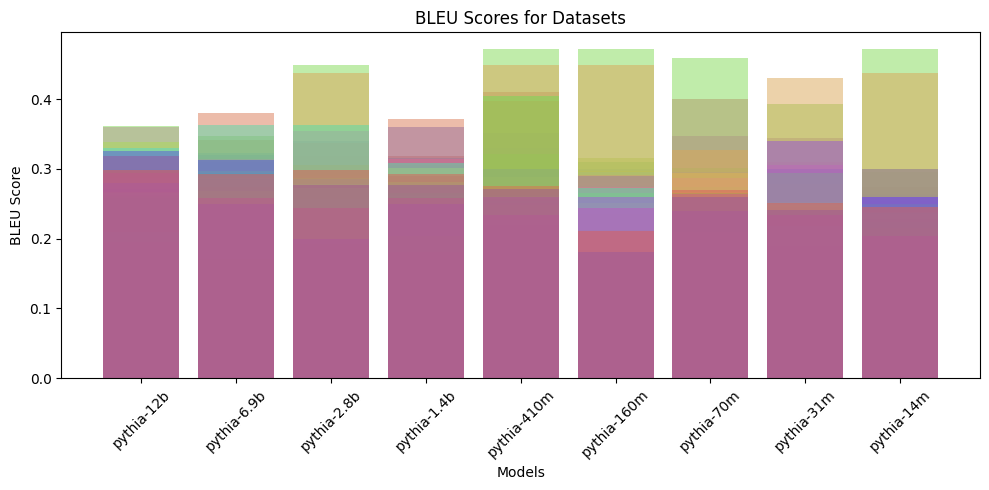

In [57]:
wa.plot_bleu_scores(results_dict, models, color_mapping)

task_ds = ds

# task_mutual_info, merged_mutual_info = wa.calculate_mutual_info(task_dfs, task_ds)
task_mutual_info, merged_mutual_info = None, None

In [58]:
model_scores, dataset_scores = wa.prepare_scores(results_dict, task_dfs, 
                                                 models, coverage_=task_cov_common,
                                                 cov_mean=task_cov_mean)

single_model = ["pythia-12b"]
single_model_score, single_model_dataset_score = wa.prepare_scores(results_dict, task_dfs, 
                                                                   single_model, coverage_=task_cov_common)

[nltk_data] Downloading package punkt to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[nltk_data] Downloading package punkt to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


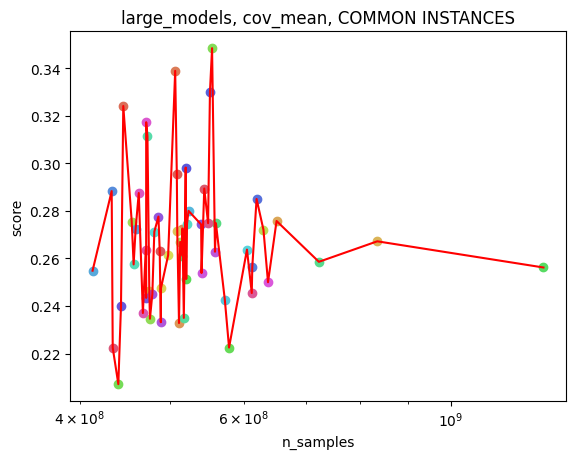

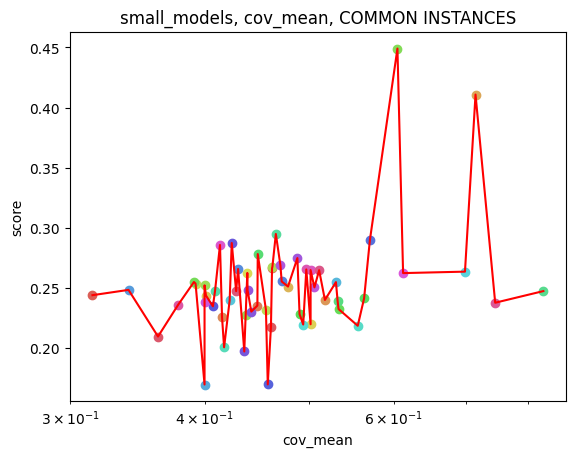

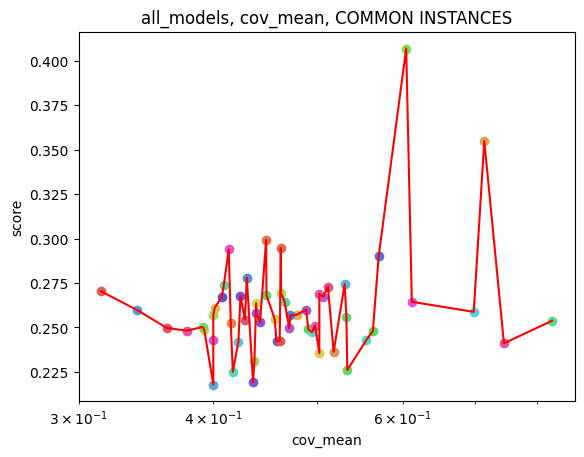

In [59]:
def plot_average_scores(dataset_scores, model_scores, color_mapping, 
                       model_list=None, x_key='n_samples',
                       log_axis=False, title=None, annotate=False):
    avg_dataset_scores = collections.defaultdict(lambda: collections.defaultdict(list))
    avg_scores = {'score': [], x_key: []} 

    for dataset in dataset_scores:
        if model_list is None:
            avg_dataset_scores[dataset]['score'] = np.mean(dataset_scores[dataset]['score'])
            avg_dataset_scores[dataset][x_key] = np.mean(dataset_scores[dataset][x_key])
        else:
            model_indices = [i for i, model in enumerate(model_scores.keys()) if model in model_list]
            avg_dataset_scores[dataset]['score'] = np.mean([dataset_scores[dataset]['score'][i] for i in model_indices])
            avg_dataset_scores[dataset][x_key] = np.mean([dataset_scores[dataset][x_key][i] for i in model_indices])

        plt.scatter(avg_dataset_scores[dataset][x_key], avg_dataset_scores[dataset]['score'], 
                    color=color_mapping[dataset], label=dataset)
        if annotate:
            plt.annotate(dataset, (avg_dataset_scores[dataset][x_key], avg_dataset_scores[dataset]['score']))
        avg_scores['score'].append(avg_dataset_scores[dataset]['score'])
        avg_scores[x_key].append(avg_dataset_scores[dataset][x_key])

    # sort by n_samples
    avg_scores['score'] = [x for _, x in sorted(zip(avg_scores[x_key], avg_scores['score']))]
    avg_scores[x_key] = sorted(avg_scores[x_key])
    
    plt.plot(avg_scores[x_key], avg_scores['score'], color='red', label='large models')
    plt.xlabel(x_key)
    plt.ylabel('score')
    if title is not None:
        plt.title(title)
    if log_axis:
        plt.xscale('log')

    if title is not None:    
        title_path = title.replace(' ', '_').replace(',', '_')
        if not os.path.exists(wa.plot_path):
            os.makedirs(wa.plot_path)
        plt.savefig(os.path.join(wa.plot_path, f"avg_scores_{title_path}.png"))
    
    plt.show()

    return avg_scores

large_models = ["pythia-12b", "pythia-6.9b", "pythia-2.8b", "pythia-1.4b"]
small_models = ["pythia-160m", "pythia-70m", "pythia-31m", "pythia-14m"]

# avg_scores = plot_average_scores(dataset_scores, model_scores, color_mapping)
avg_scores_large = plot_average_scores(dataset_scores, model_scores, 
                                      color_mapping, large_models,
                                      log_axis=LOG_AXIS,
                                      title="large_models, cov_mean, COMMON INSTANCES",)
avg_scores_small = plot_average_scores(dataset_scores, model_scores,
                                        color_mapping, small_models,
                                        log_axis=LOG_AXIS,
                                        x_key='cov_mean',
                                        title="small_models, cov_mean, COMMON INSTANCES",)
avg_scores = plot_average_scores(dataset_scores, model_scores,
                                        color_mapping, models,
                                        log_axis=LOG_AXIS,
                                        x_key='cov_mean',
                                        title="all_models, cov_mean, COMMON INSTANCES",)
# avg_scores_small = plot_average_scores(dataset_scores, model_scores, color_mapping, small_models)

# plt.plot(avg_scores['n_samples'], avg_scores['score'], color='black', label='all models')
# plt.plot(avg_scores_small['n_samples'], avg_scores_small['score'], color='blue', label='small models')

[nltk_data] Downloading package punkt to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


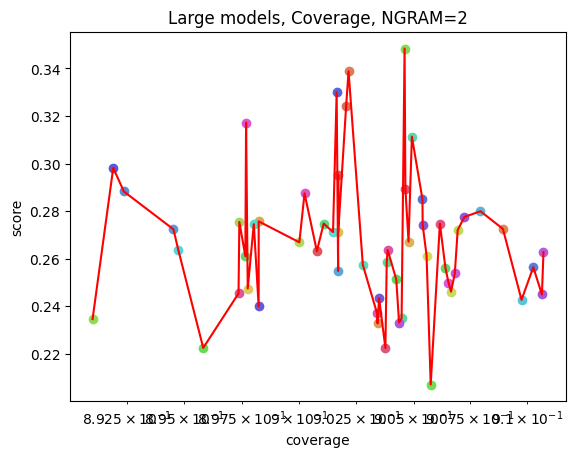

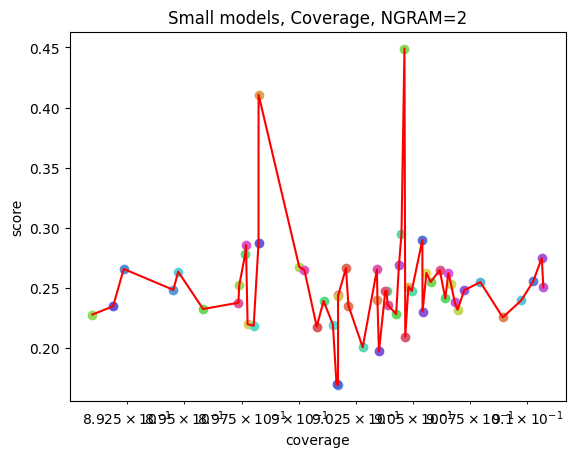

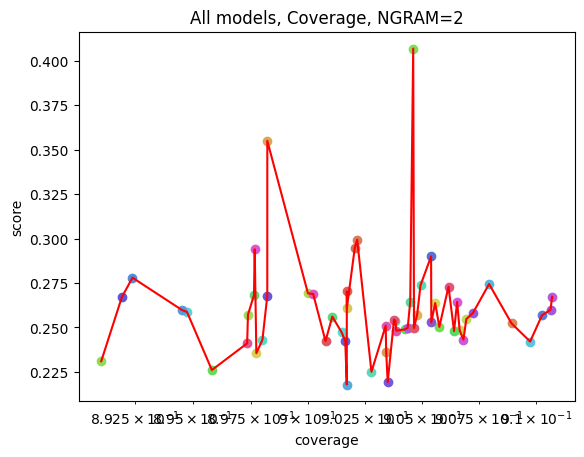

In [60]:
avg_scores_large = plot_average_scores(dataset_scores, model_scores, 
                                      color_mapping, large_models,
                                      log_axis=LOG_AXIS,
                                      x_key='coverage',
                                      title=f"Large models, Coverage, NGRAM={N_GRAMS}")
avg_scores_small = plot_average_scores(dataset_scores, model_scores,
                                        color_mapping, small_models,
                                        log_axis=LOG_AXIS,
                                        x_key='coverage',
                                        title=f"Small models, Coverage, NGRAM={N_GRAMS}")
avg_scores = plot_average_scores(dataset_scores, model_scores,
                                        color_mapping, models,
                                        log_axis=LOG_AXIS,
                                        x_key='coverage',
                                        title=f"All models, Coverage, NGRAM={N_GRAMS}")

In [61]:
import plotly.graph_objs as go
import collections
import numpy as np


# Modified function to create an interactive plot using Plotly within a Jupyter Notebook
def plot_average_scores_plotly(dataset_scores, model_scores, color_mapping, 
                              model_list=None, x_key='n_samples',
                              log_axis=False, title=None):
    avg_dataset_scores = collections.defaultdict(lambda: collections.defaultdict(list))
    avg_scores = {'score': [], x_key: []} 

    # Create Plotly figure
    fig = go.Figure()

    for dataset in dataset_scores:
        if model_list is None:
            avg_dataset_scores[dataset]['score'] = np.mean(dataset_scores[dataset]['score'])
            avg_dataset_scores[dataset][x_key] = np.mean(dataset_scores[dataset][x_key])
        else:
            model_indices = [i for i, model in enumerate(model_scores.keys()) if model in model_list]
            avg_dataset_scores[dataset]['score'] = np.mean([dataset_scores[dataset]['score'][i] for i in model_indices])
            avg_dataset_scores[dataset][x_key] = np.mean([dataset_scores[dataset][x_key][i] for i in model_indices])

        # Append data for plotting
        avg_scores['score'].append(avg_dataset_scores[dataset]['score'])
        avg_scores[x_key].append(avg_dataset_scores[dataset][x_key])
        
        # Add trace for each dataset to the figure
        fig.add_trace(go.Scatter(
            x=[avg_dataset_scores[dataset][x_key]],
            y=[avg_dataset_scores[dataset]['score']],
            text=[dataset],  # Will show this text on hover
            mode='markers',
            marker=dict(color=color_mapping[dataset]),
            name=dataset
        ))

    # sort by x_key (e.g., 'n_samples')
    sorted_indices = np.argsort(avg_scores[x_key])
    sorted_scores = np.array(avg_scores['score'])[sorted_indices]
    sorted_x_values = np.array(avg_scores[x_key])[sorted_indices]

    # Add sorted average line to the figure
    fig.add_trace(go.Scatter(
        x=sorted_x_values,
        y=sorted_scores,
        mode='lines',
        marker=dict(color='red'),
        name='Average'
    ))

    # Set log axis if specified
    if log_axis:
        fig.update_xaxes(type='log')

    # Update layout with title and axis labels
    fig.update_layout(
        title=title,
        xaxis_title=x_key,
        yaxis_title='Score',
        hovermode='closest'
    )

    # disable legend
    fig.update_layout(showlegend=False)

    # Show figure
    fig.show()

    return avg_scores

avg_scores = plot_average_scores_plotly(dataset_scores, 
                                       model_scores, 
                                       color_mapping,
                                       model_list=large_models,
                                       log_axis=LOG_AXIS,
                                       x_key='cov_mean',)

In [62]:
# Assuming your dictionary is named `dataset_scores`
sorted_data = sorted(dataset_scores.items(), key=lambda x: max(x[1]['n_samples']), reverse=True)
top_5_datasets = {k: v['n_samples'] for k, v in sorted_data[:5]}
print(f"Top 5 datasets: {top_5_datasets}")

Top 5 datasets: {'professional_law': [1257027132, 1257027132, 1257027132, 1257027132, 1257027132, 1257027132, 1257027132, 1257027132, 1257027132], 'elementary_mathematics': [833947426, 833947426, 833947426, 833947426, 833947426, 833947426, 833947426, 833947426, 833947426], 'high_school_us_history': [722024237, 722024237, 722024237, 722024237, 722024237, 722024237, 722024237, 722024237, 722024237], 'professional_medicine': [650388531, 650388531, 650388531, 650388531, 650388531, 650388531, 650388531, 650388531, 650388531], 'college_mathematics': [636792158, 636792158, 636792158, 636792158, 636792158, 636792158, 636792158, 636792158, 636792158]}


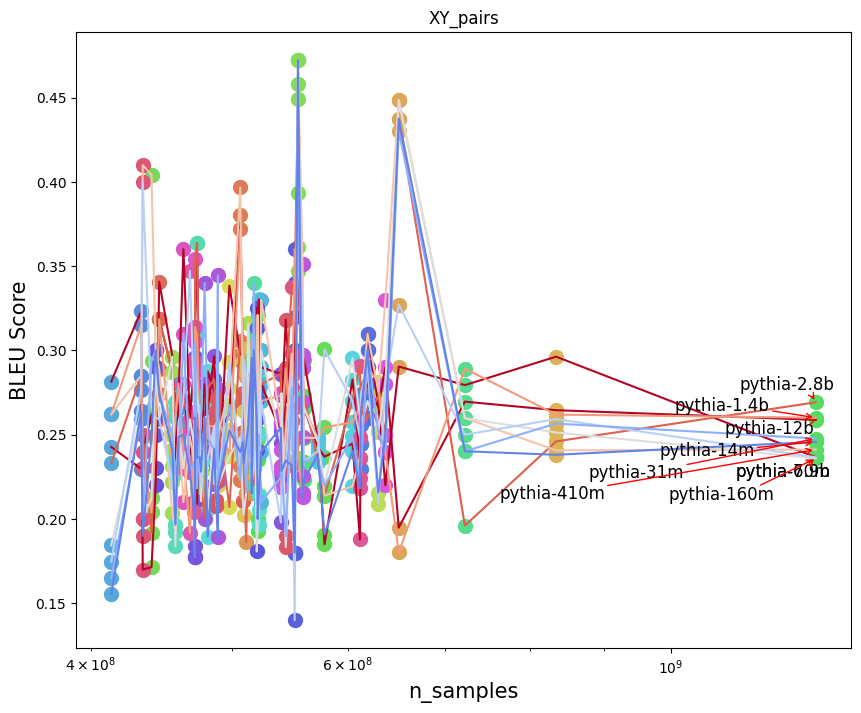

In [63]:
import matplotlib.pyplot as plt
from adjustText import adjust_text


# wa.plot_scores(model_scores, dataset_scores, model_color_mapping, name="XY_pairs")
wa.plot_scores(model_scores, dataset_scores, color_mapping,
               model_color_mapping, name="XY_pairs",
               log_axis=True)

In [64]:
# wa.plot_scores(single_model_score, single_model_dataset_score, color_mapping,
#                model_color_mapping, name="XY_pairs",
#                log_axis=True, x_key='coverage')

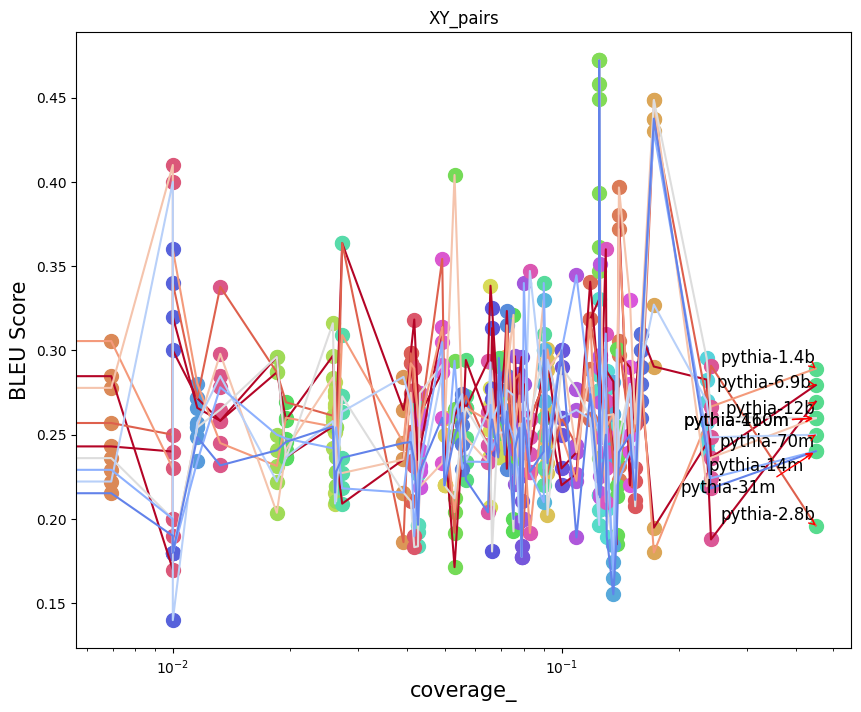

In [65]:
wa.plot_scores(model_scores, dataset_scores, color_mapping,
            model_color_mapping, name="XY_pairs",
            x_key='coverage_', log_axis=True)


In [66]:
['pythia-12b', 'pythia-6.9b', 'pythia-2.8b', 'pythia-1.4b', 'pythia-410m', 'pythia-160m', 'pythia-70m', 'pythia-31m', 'pythia-14m']

model_param_map = {'pythia-12b': 12e09,
                    'pythia-6.9b': 6.9e09,
                    'pythia-2.8b': 2.8e09,
                    'pythia-1.4b': 1.4e09,
                    'pythia-410m': 410e06,
                    'pythia-160m': 160e06,
                    'pythia-70m': 70e06,
                    'pythia-31m': 31e06,
                    'pythia-14m': 14e06,}

# wa.plot_model_size_vs_scores(results_dict, models, model_param_map, color_mapping)


In [67]:
task_dfs_all = wa.get_task_dfs(BASE_PATH_ALL, TASKS)

# wa.analyze_and_plot_distributions(task_dfs_all)


In [ ]:
# get total samples per language
task_dfs_all_total_samples = {}
for lang, df in task_dfs_all.items():
    task_dfs_all_total_samples[lang] = df['value'].sum()

model_scores_all, dataset_scores_all = wa.prepare_scores(results_dict, task_dfs_all, models,
                                                         coverage_=task_cov_all,
                                                         cov_mean=task_cov_mean)

In [ ]:
# n_gram_freqs_all['ja-en']['value'] = pd.to_numeric(n_gram_freqs_all['ja-en']['value'], errors='coerce')
# largest_values = n_gram_freqs_all['ja-en'].nlargest(50, columns=['value'])

# print(largest_values)


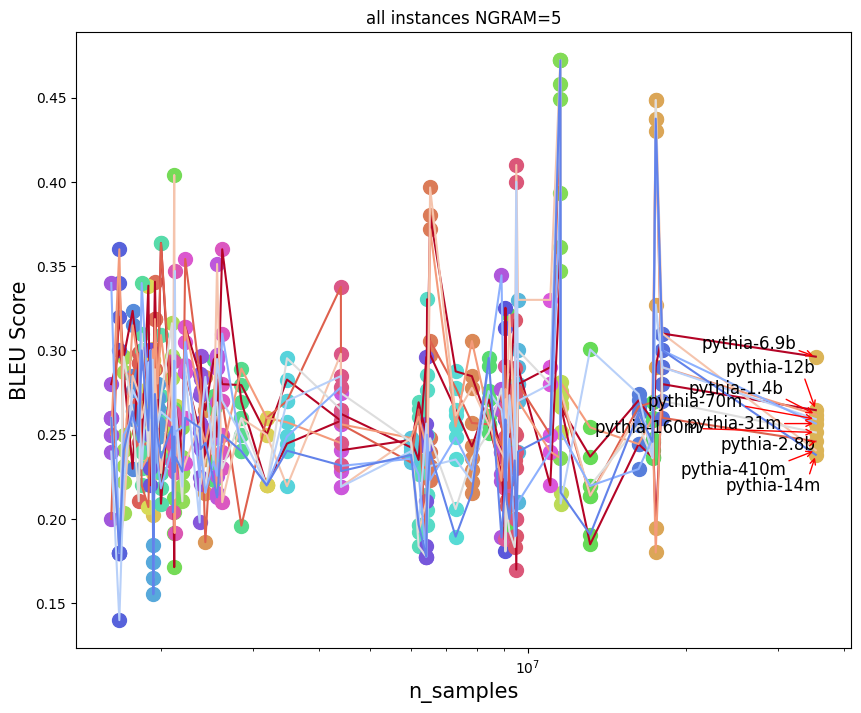

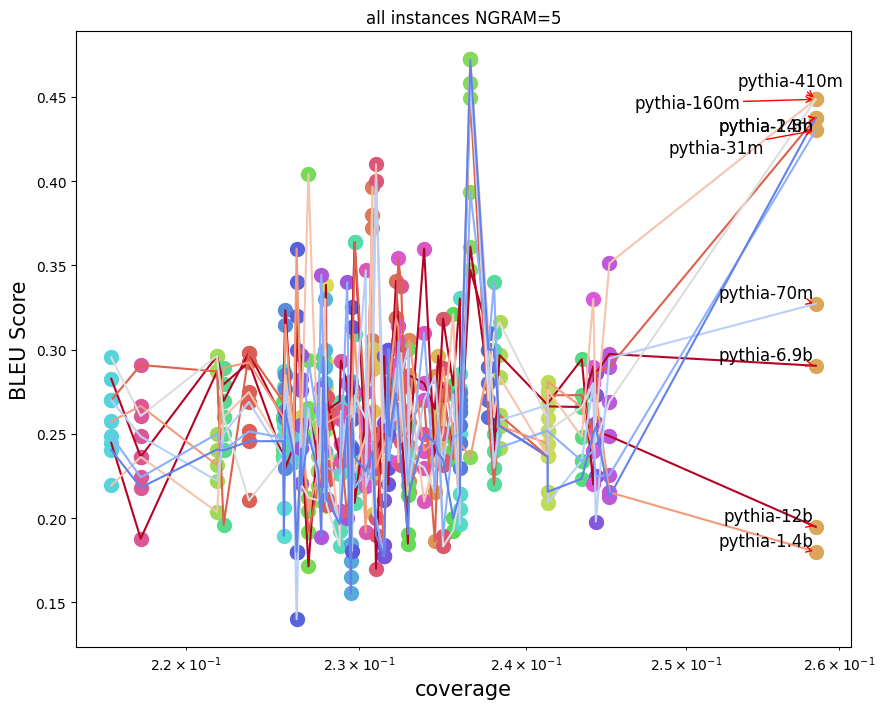

In [ ]:
wa.plot_scores(model_scores_all, dataset_scores_all, 
            color_mapping, model_color_mapping, 
            name=f"all instances NGRAM={N_GRAMS}",
            log_axis=LOG_AXIS)

wa.plot_scores(model_scores_all, dataset_scores_all, 
            color_mapping, model_color_mapping, 
            name=f"all instances NGRAM={N_GRAMS}",
            x_key="coverage",
            log_axis=LOG_AXIS)


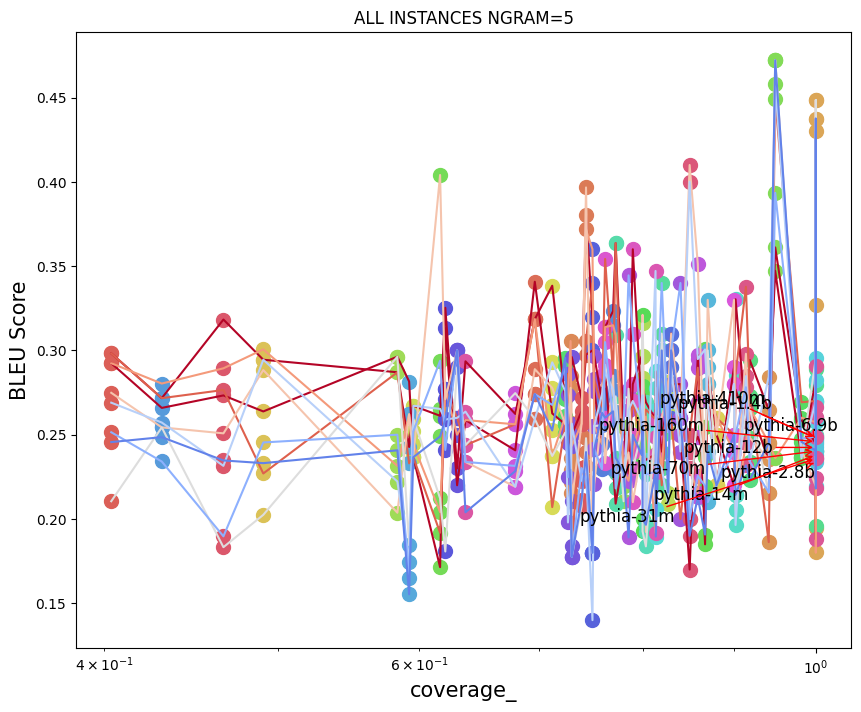

In [ ]:
wa.plot_scores(model_scores_all, dataset_scores_all, 
            color_mapping, model_color_mapping, 
            name=f"ALL INSTANCES NGRAM={N_GRAMS}",
            x_key="coverage_",
            log_axis=LOG_AXIS)

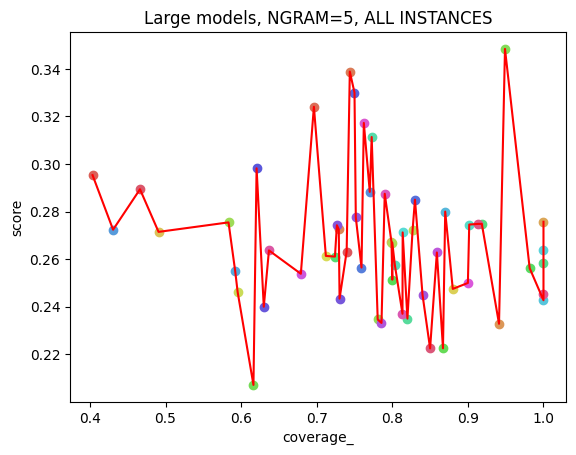

In [ ]:
avg_scores_large_all = plot_average_scores(dataset_scores_all, model_scores_all, 
                                          color_mapping, large_models,
                                          x_key='coverage_', log_axis=False,
                                          title=f"Large models, NGRAM={N_GRAMS}, ALL INSTANCES")

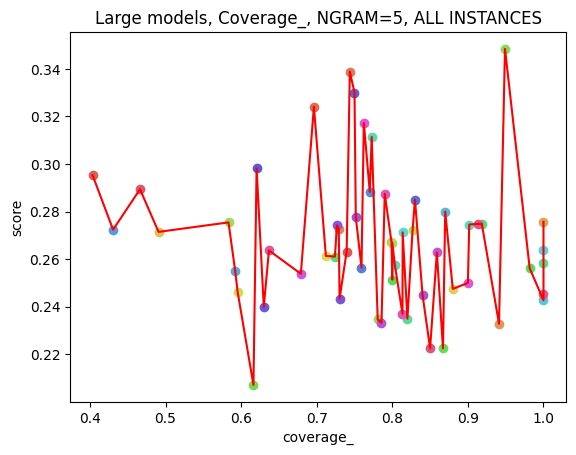

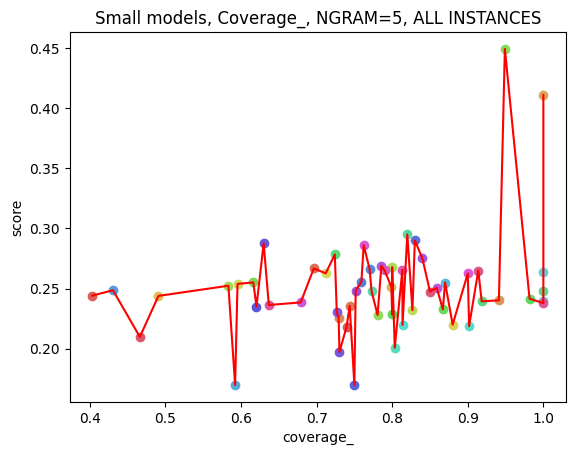

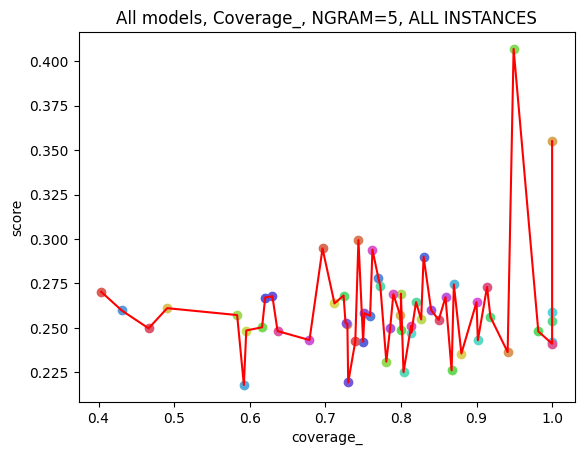

In [ ]:
avg_scores_large_all = plot_average_scores(dataset_scores_all, model_scores_all, 
                                          color_mapping, large_models,
                                          x_key='coverage_', log_axis=False,
                                          title=f"Large models, Coverage_, NGRAM={N_GRAMS}, ALL INSTANCES")
avg_scores_small_all = plot_average_scores(dataset_scores_all, model_scores_all,
                                          color_mapping, small_models,
                                          x_key='coverage_', log_axis=False,
                                          title=f"Small models, Coverage_, NGRAM={N_GRAMS}, ALL INSTANCES")
avg_scores_all = plot_average_scores(dataset_scores_all, model_scores_all,
                                    color_mapping, models,
                                    x_key='coverage_', log_axis=False,
                                    title=f"All models, Coverage_, NGRAM={N_GRAMS}, ALL INSTANCES")

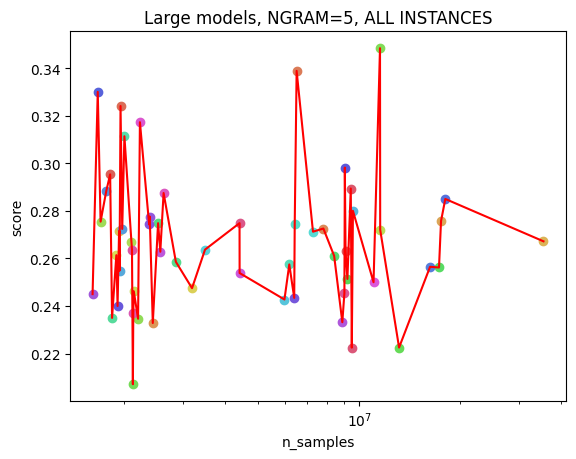

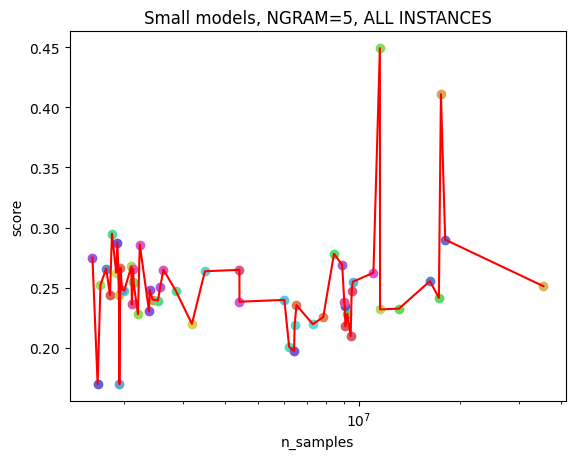

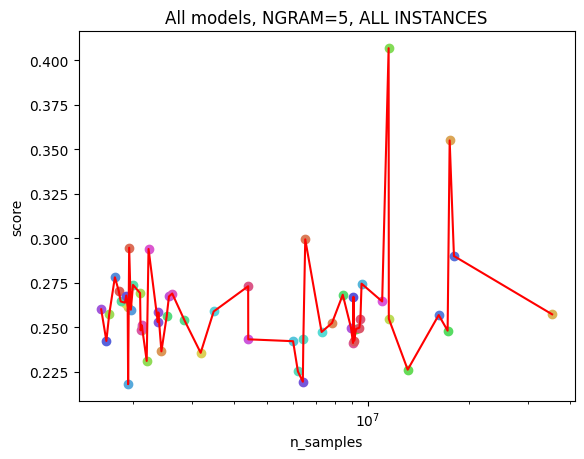

In [ ]:
avg_scores_large_all = plot_average_scores(dataset_scores_all, model_scores_all, 
                                          color_mapping, large_models,
                                          x_key='n_samples', log_axis=True,
                                          title=f"Large models, NGRAM={N_GRAMS}, ALL INSTANCES")
avg_scores_small_all = plot_average_scores(dataset_scores_all, model_scores_all,
                                          color_mapping, small_models,
                                          x_key='n_samples', log_axis=True,
                                          title=f"Small models, NGRAM={N_GRAMS}, ALL INSTANCES")
avg_scores_all = plot_average_scores(dataset_scores_all, model_scores_all,
                                    color_mapping, models,
                                    x_key='n_samples', log_axis=True,
                                    title=f"All models, NGRAM={N_GRAMS}, ALL INSTANCES")

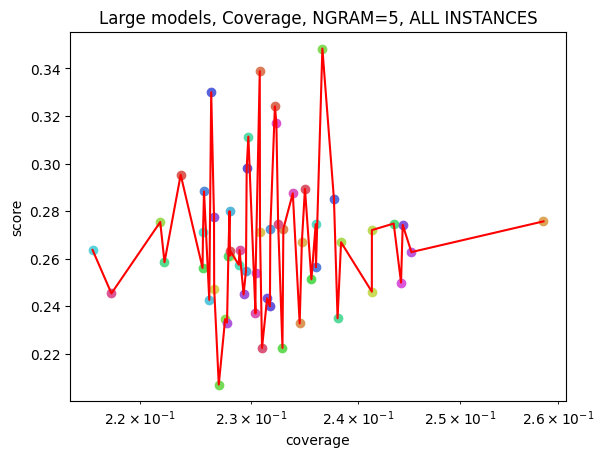

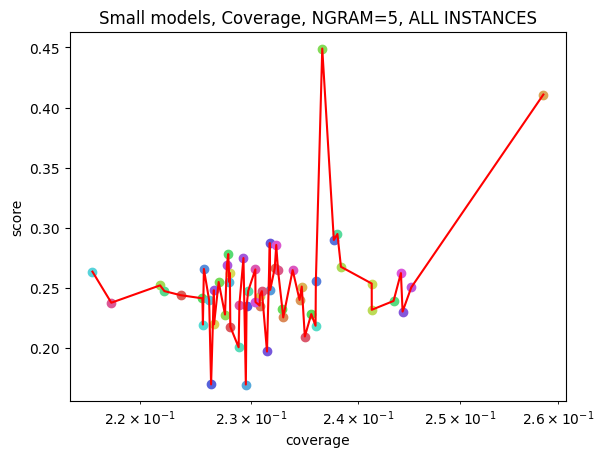

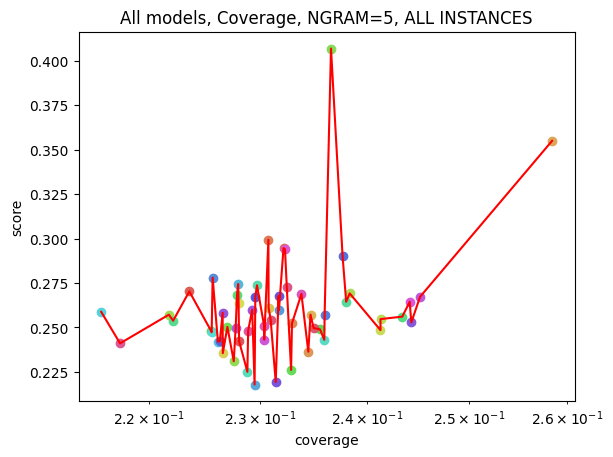

In [ ]:
avg_scores_large_all = plot_average_scores(dataset_scores_all, model_scores_all, 
                                          color_mapping, large_models,
                                          x_key='coverage', log_axis=True,
                                          title=f"Large models, Coverage, NGRAM={N_GRAMS}, ALL INSTANCES")
avg_scores_small_all = plot_average_scores(dataset_scores_all, model_scores_all,
                                          color_mapping, small_models,
                                          x_key='coverage', log_axis=True,
                                          title=f"Small models, Coverage, NGRAM={N_GRAMS}, ALL INSTANCES")
avg_scores_all = plot_average_scores(dataset_scores_all, model_scores_all,
                                    color_mapping, models,
                                    x_key='coverage', log_axis=True,
                                    title=f"All models, Coverage, NGRAM={N_GRAMS}, ALL INSTANCES")

In [ ]:
plot_key = 'n_samples'
avg_scores_large_all = plot_average_scores_plotly(dataset_scores_all, model_scores_all, 
                                          color_mapping, large_models,
                                          x_key=plot_key, log_axis=False,
                                          title=f"large models, NGRAM={N_GRAMS}, ALL INSTANCES")
avg_scores_small_all = plot_average_scores_plotly(dataset_scores_all, model_scores_all,
                                          color_mapping, small_models,
                                          x_key=plot_key, log_axis=False,
                                          title=f"small models, NGRAM={N_GRAMS}, ALL INSTANCES")
avg_scores_all = plot_average_scores_plotly(dataset_scores_all, model_scores_all,
                                    color_mapping, None,
                                    x_key=plot_key, log_axis=False,
                                    title=f"all models, NGRAM={N_GRAMS}, ALL INSTANCES")

In [ ]:
# wa.plot_scores(model_scores, dataset_scores, 
#             color_mapping, model_color_mapping, 
#             name="XY_pairs", log_axis=LOG_AXIS,
#             x_key="coverage")


In [ ]:
coverage_common

,task,example,coverage
0,abstract_algebra,{'question': 'Find the degree for the given fi...,0
1,abstract_algebra,"{'question': 'Let p = (1, 2, 5, 4)(2, 3) in S_...",0
2,abstract_algebra,{'question': 'Find all zeros in the indicated ...,0
3,abstract_algebra,{'question': 'Statement 1 | A factor group of ...,0
4,abstract_algebra,{'question': 'Find the product of the given po...,0
...,...,...,...
14037,world_religions,{'question': 'What has been a central focus of...,0
14038,world_religions,{'question': ' To whom did ordinary folk appea...,0
14039,world_religions,{'question': ' The theological term homoousios...,0
14040,world_religions,{'question': 'According to the Japanese origin...,0
